# Statistics of ideal mixing
Testing the equilibrium properties of the `SaltSwap` code by exchanging water molecules with water molecules. Non-bonded parameters will be 'updated' to their current values. Therefore, the identities of 'cations' and 'anions' should come in via diffusion.

In [1]:
from simtk import openmm, unit
from simtk.openmm import app
from openmmtools.testsystems import WaterBox
import sys
sys.path.append("../saltswap/")
sys.path.append("../SAMS/")
from calibrate import MCMCSampler
from saltswap import SaltSwap
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

As with other notebooks, the test system will be small box of water.

In [2]:
size = 20.0*unit.angstrom     
temperature = 300*unit.kelvin
pressure = 1*unit.atmospheres
delta_chem = 0*unit.kilojoule_per_mole
wbox = WaterBox(box_edge=size,nonbondedMethod=app.PME)
Nmols = wbox.system.getNumParticles()/3.0

In [26]:
# Nice colours, taken on 26th Nov 2015 from:
#http://tableaufriction.blogspot.co.uk/2012/11/finally-you-can-use-tableau-data-colors.html

# These are the "Tableau" colors as RGB. I've chosen my faves. 
# In order: blue, green, purple, orange. Hopefully a good compromise for colour-blind people.
tableau4 = [(31, 119, 180),(44, 160, 44),(148,103,189),(255, 127, 14)]
tableau4_light = [(174,199,232),(152,223,138),(197,176,213),(255,187,120)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts. 
for i in range(len(tableau4)):    
    r, g, b = tableau4[i]    
    tableau4[i] = (r / 255., g / 255., b / 255.)
    r, g, b = tableau4_light[i]    
    tableau4_light[i] = (r / 255., g / 255., b / 255.)

# The effect of shadow work on the acceptance rate.

Initialising the `MCMCSampler` object and changing the ion parameters to the same as water, so that there is no change in energy when salt is 'added'.

In [89]:
state = MCMCSampler(wbox.system,wbox.topology,wbox.positions)
state.saltswap.cation_parameters = state.saltswap.water_parameters
state.saltswap.anion_parameters = state.saltswap.water_parameters

**INSTANT SWITCHES**

In [90]:
Nwats = []
Nsalts = []
for block in range(500):
    state.gen_label(saltsteps=20)
    (nwats,nsalt,junk) = state.saltswap.getIdentityCounts()
    Nwats.append(nwats)
    Nsalts.append(nsalt)

In [5]:
inst_work_add = np.array(state.saltswap.work_add)
inst_work_rm = np.array(state.saltswap.work_rm)
print np.sum(inst_work_add<0)/(1.0*inst_work_add.shape[0])
print np.sum(inst_work_rm<0)/(1.0*inst_work_rm.shape[0])

0.239008792966
0.241192954363


Viewing the average number of salt pairs as time progresses:

Mean fraction of water molecules = 0.331 +/- 0.0559
Mean fraction of cations = 0.334 +/- 0.028
Acceptance probability = 0.905
Ratio of variance: std(water)/std(cation) = 2.000


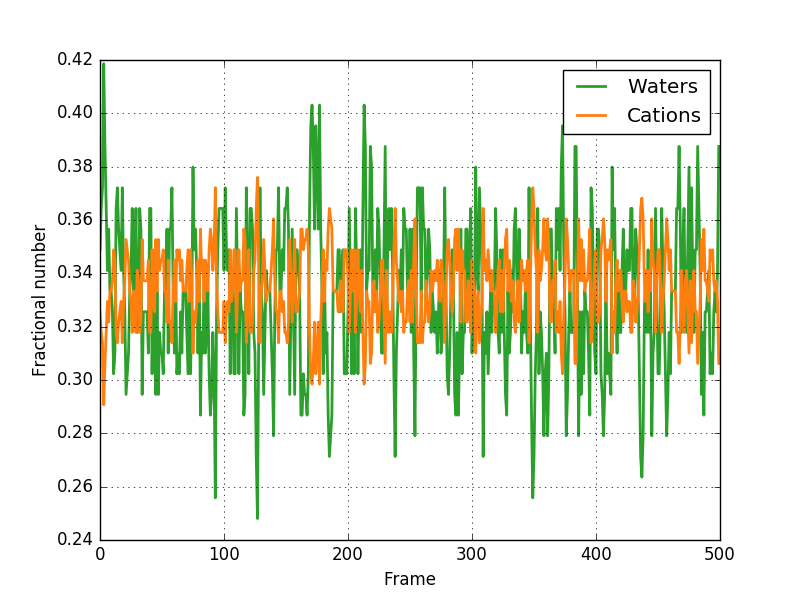

In [91]:
time = np.arange(len(Nwats))
Nwats = np.array(Nwats)
Nsalts = np.array(Nsalts)

plt.clf()
plt.grid(True)
plt.plot(Nwats/Nmols,color=tableau4[1],linewidth=2)
#plt.plot(Nwats/Nmols,color=tableau4_light[1],linewidth=1)
plt.plot(Nsalts/Nmols,color=tableau4[3],linewidth=2)
#plt.plot(Nsalts/Nmols,color=tableau4_light[3],linewidth=1)
plt.xlabel('Frame')
plt.ylabel('Fractional number')
plt.legend(['Waters','Cations'])
plt.savefig('InstSwictch.png',format='png')
print 'Mean fraction of water molecules = {:.3f} +/- {:.3}'.format((Nwats/Nmols).mean(),2*(Nwats/Nmols).std())
print 'Mean fraction of cations = {:.3f} +/- {:.3}'.format((Nsalts/Nmols).mean(),2*(Nsalts/Nmols).std())
print 'Acceptance probability = {:.3f}'.format(state.saltswap.getAcceptanceProbability())
print 'Ratio of variance: std(water)/std(cation) = {:.3f}'.format(Nwats.std()/Nsalts.std())
Image('InstSwictch.png')

**NCMC**

Number of perturbation kernels = 512,
Number of propagation kernels = 1

In [7]:
ncstate = MCMCSampler(wbox.system,wbox.topology,wbox.positions,nkernels = 500,nverlet=1)
ncstate.saltswap.cation_parameters = ncstate.saltswap.water_parameters
ncstate.saltswap.anion_parameters = ncstate.saltswap.water_parameters

In [8]:
ncNwats = []
ncNsalts = []
for block in range(500):
    ncstate.gen_label(saltsteps=20)
    (nwats,nsalt,junk) = ncstate.saltswap.getIdentityCounts()
    ncNwats.append(nwats)
    ncNsalts.append(nsalt)

In [9]:
nc_work_add = np.array(ncstate.saltswap.work_add)
nc_work_rm = np.array(ncstate.saltswap.work_rm)
print np.sum(nc_work_add<0)/(1.0*nc_work_add.shape[0])
print np.sum(nc_work_rm<0)/(1.0*nc_work_rm.shape[0])

0.546383490283
0.545617887802


Mean fraction of water molecules = 0.331 +/- 0.212
Mean fraction of cations = 0.335 +/- 0.106
Acceptance probability = 0.568
Ratio of variance: std(water)/std(cation) = 2.000


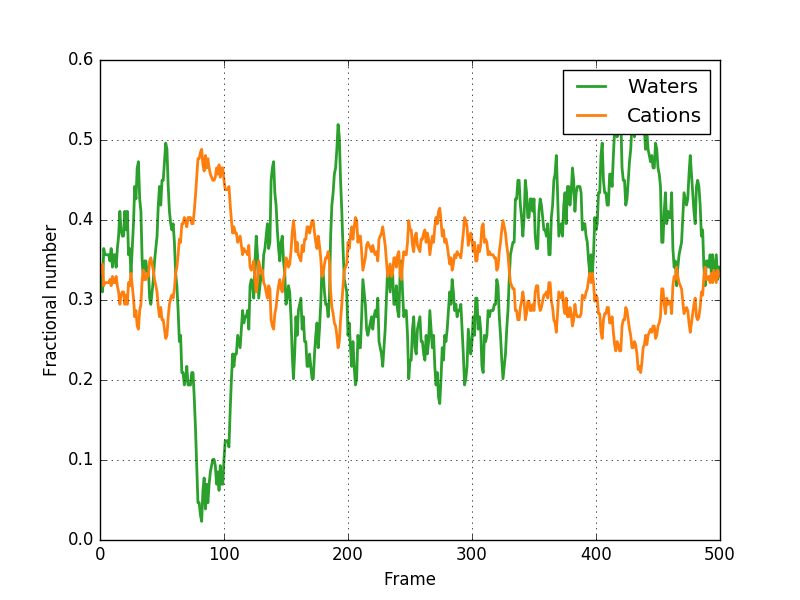

In [88]:
time = np.arange(len(ncNwats))
ncNwats = np.array(ncNwats)
ncNsalts = np.array(ncNsalts)

plt.clf()
plt.grid(True)
plt.plot(ncNwats/Nmols,color=tableau4[1],linewidth=2)
#plt.plot(Nwats/Nmols,color=tableau4_light[1],linewidth=1)
plt.plot(ncNsalts/Nmols,color=tableau4[3],linewidth=2)
#plt.plot(Nsalts/Nmols,color=tableau4_light[3],linewidth=1)
plt.xlabel('Frame')
plt.ylabel('Fractional number')
plt.legend(['Waters','Cations'])
plt.savefig('NCMC_nk500_nV1.png',format='png')
print 'Mean fraction of water molecules = {:.3f} +/- {:.3}'.format((ncNwats/Nmols).mean(),2*(ncNwats/Nmols).std())
print 'Mean fraction of cations = {:.3f} +/- {:.3}'.format((ncNsalts/Nmols).mean(),2*(ncNsalts/Nmols).std())
print 'Acceptance probability = {:.3f}'.format(ncstate.saltswap.getAcceptanceProbability())
print 'Ratio of variance: std(water)/std(cation) = {:.3f}'.format(ncNwats.std()/ncNsalts.std())
Image('NCMC_nk500_nV1.png')

## Work distributions due to shadow work

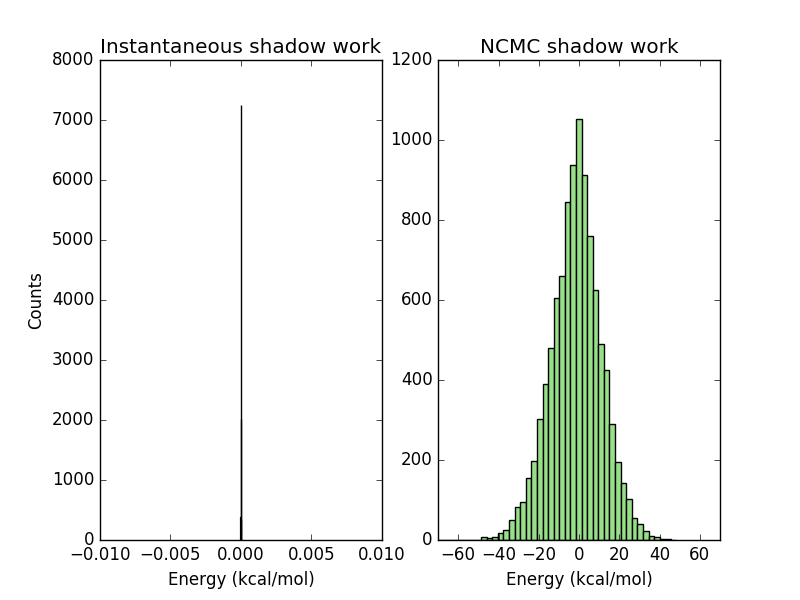

In [63]:
plt.clf()
#n, bins, patches = plt.hist(nc_work_rm, 50, normed=1, facecolor=tableau4_light[2])

plt.savefig('temp.png',format='png')
Image('temp.png')

f, axarr = plt.subplots(1, 2)
coords = [(0,0),(0,1)]
xlims =(-70,70)       # x limits
ylims = (0,0.025)       # y limits


axarr[0].hist(np.hstack((inst_work_add,inst_work_rm))*0.592, 5, normed=False, facecolor=tableau4_light[2])
axarr[0].set_xlim({-0.01,0.01})
#axarr[0].set_xlim(xlims)
#axarr[0].set_ylim(ylims)
axarr[0].set_xlabel('Energy (kcal/mol)')
axarr[0].set_ylabel('Counts')
axarr[0].set_title('Instantaneous shadow work')
axarr[1].hist(np.hstack((nc_work_add,nc_work_rm))*0.592, 50, normed=False, facecolor=tableau4_light[1])
axarr[1].set_xlim(xlims)
#axarr[1].set_ylim(ylims)
axarr[1].set_xlabel('Energy (kcal/mol)')
axarr[1].set_title('NCMC shadow work')
#plt.setp(axarr[1].get_yticklabels(),visible=False)  

plt.savefig("ShadowWork.png", format='png')
Image("ShadowWork.png")

In [86]:
(nc_work_add>0).sum()/(1.0*nc_work_add.shape[0])

0.45361650971749151